## Mengumpulkan dan Melabeli Data dalam NLP

Ketika kita ingin memproses data teks dari web, biasanya data tersebut tidak memiliki label. Artinya, data tersebut tidak bisa langsung digunakan dalam model yang diawasi (supervised). Namun, data ini tetap berguna. Dengan menggunakan **transfer learning**, kita bisa melatih model bahasa menggunakan metode yang tidak diawasi (unsupervised) atau semi-diawasi (semi-supervised). Model ini kemudian bisa digunakan dengan dataset pelatihan kecil yang spesifik untuk tugas tertentu.

**Apa itu Transfer Learning?** Transfer learning adalah teknik di mana model yang sudah dilatih pada satu tugas digunakan kembali untuk tugas lain. Misalnya, kita bisa melatih model bahasa besar dengan data yang tidak berlabel, lalu menggunakan model ini untuk tugas spesifik seperti klasifikasi spam dengan dataset kecil yang berlabel.

**Langkah Melabeli Data**: Setelah mengumpulkan data teks, langkah berikutnya adalah melabeli data tersebut dengan kelas yang tepat. Contohnya:
- **Klasifikasi Spam**: Jika tugasnya adalah membuat pengklasifikasi spam untuk email, kita perlu mengumpulkan banyak email. Langkah melabeli adalah memberi label "spam" atau "bukan spam" pada setiap email.
- **Deteksi Sentimen**: Jika tugasnya adalah mendeteksi sentimen pada tweet, kita perlu mengumpulkan banyak tweet. Langkah melabeli adalah memberi label sentimen seperti "positif", "negatif", atau "netral" pada setiap tweet.
- **Ringkasan Artikel Berita**: Jika tugasnya adalah merangkum artikel berita, kita perlu mengumpulkan banyak artikel berita. Langkah melabeli adalah membuat ringkasan untuk setiap artikel.

**Tantangan dalam Melabeli Data**: Melabeli data bisa sangat memakan waktu dan sumber daya. Oleh karena itu, ada banyak fokus pada pendekatan semi-diawasi untuk melabeli data. Misalnya, kita bisa menggunakan perpustakaan seperti Snorkel untuk melabeli data dalam skala besar dengan metode semi-diawasi.

**Dataset yang Tersedia Secara Publik**: Ada banyak dataset yang tersedia di web untuk melatih model. Dengan menggunakan transfer learning, dataset umum ini bisa digunakan untuk memulai model pembelajaran mesin, lalu kita bisa menggunakan sedikit data spesifik domain untuk menyempurnakan model. Keuntungan menggunakan dataset publik adalah:
1. Pengumpulan data sudah dilakukan.
2. Pelabelan sudah dilakukan.
3. Kita bisa membandingkan hasil dengan standar terkini karena banyak makalah penelitian menggunakan dataset spesifik dan mempublikasikan benchmark.

Contoh dataset yang sering digunakan adalah **Stanford Question Answering Dataset (SQuAD)**, yang sering digunakan sebagai benchmark untuk model tanya jawab.

In [1]:
import sys
from pathlib import Path

config_path = Path('../../Natural-Language-Processing')
sys.path.append(str(config_path))

In [2]:
from config import \
    DATASET_PATH, \
    MODEL_PATH, \
    BATCH_SIZE, \
    TRAIN_PROPORTION, \
    INPUT_SHAPE_MODEL_V1, \
    NUM_LABEL, \
    OPTIMIZER, \
    LOSS, \
    METRICS

from Src import DatasetSplitter, SpamLDetectionModel
from Src import evaluate_model, minmax_scaling_tf

from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE

import sklearn
import imblearn
import matplotlib
import unicodedata
import spacy

import tensorflow as tf 
import pandas as pd
import numpy as np
import seaborn as sns

print(f'tensorflow version: {tf.__version__}')
print(f'sklearn version: {sklearn.__version__}')
print(f'imblearn version: {imblearn.__version__}')
print(f'spacy version: {spacy.__version__}')
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'seaborn version: {sns.__version__}')

tensorflow version: 2.16.1
sklearn version: 1.5.1
imblearn version: 0.12.3
spacy version: 3.7.5
numpy version: 1.26.2
pandas version: 2.1.3
matplotlib version: 3.9.0
seaborn version: 0.13.2


In [3]:
with open(DATASET_PATH, 'r') as file:
    for idx, line in enumerate(file, 1):
        line = line.strip()
        display(line)
        if idx == 5:
            break

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

'ham\tOk lar... Joking wif u oni...'

"spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

'ham\tU dun say so early hor... U c already then say...'

"ham\tNah I don't think he goes to usf, he lives around here though"

In [4]:
df = pd.read_csv(DATASET_PATH, sep='\t', names=['label', 'message'])

In [5]:
df[:5]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Normalisasi Teks dalam NLP

**Normalisasi teks** adalah langkah awal dalam pemrosesan teks yang bertujuan untuk meningkatkan kualitas teks dan membuatnya lebih mudah diproses oleh mesin. Ada empat langkah utama dalam normalisasi teks:

1. **Normalisasi Huruf Besar-Kecil (Case Normalization)**
2. **Tokenisasi dan Penghapusan Kata Umum (Stop Word Removal)**
3. **Penandaan Bagian dari Ucapan (Parts-of-Speech Tagging)**
4. **Stemming**

#### 1. Normalisasi Huruf Besar-Kecil
Normalisasi huruf besar-kecil berlaku untuk bahasa yang menggunakan huruf besar dan kecil, seperti alfabet Latin atau Sirilik (misalnya, bahasa Rusia dan Mongolia). Dalam langkah ini, semua huruf diubah menjadi huruf kecil atau besar. Ini membantu dalam kasus penggunaan semantik, tetapi bisa mengurangi kinerja dalam beberapa kasus lain. Misalnya, pesan spam mungkin memiliki lebih banyak kata dengan huruf besar dibandingkan pesan biasa.

#### 2. Tokenisasi dan Penghapusan Kata Umum
Tokenisasi adalah proses memecah teks menjadi unit-unit kecil seperti kata atau frasa. Setelah itu, kata-kata umum yang tidak memberikan banyak informasi (seperti "dan", "atau", "tetapi") dihapus. Ini membantu fokus pada kata-kata yang lebih penting.

#### 3. Penandaan Bagian dari Ucapan (POS Tagging)
Penandaan bagian dari ucapan adalah proses memberi label pada setiap kata dalam teks dengan kategori gramatikalnya, seperti kata benda, kata kerja, atau kata sifat. Ini membantu memahami struktur kalimat dan hubungan antar kata.

#### 4. Stemming
Stemming adalah proses mengubah kata ke bentuk dasarnya. Misalnya, kata "running" diubah menjadi "run". Ini membantu mengurangi variasi kata sehingga mesin bisa lebih mudah memprosesnya.

#### Contoh Normalisasi Teks
Misalkan kita ingin membangun model dasar dengan tiga fitur sederhana:
- Jumlah karakter dalam pesan
- Jumlah huruf besar dalam pesan
- Jumlah simbol tanda baca dalam pesan

Langkah-langkah normalisasi ini membantu kita mempersiapkan teks agar lebih mudah dianalisis dan diproses oleh model pembelajaran mesin.

In [6]:
# Normalization functions

def message_length(x):
    # returns total number of characters
    return len(x)

def num_capitals(x):
    count = sum(1 for char in x if char.isupper())
    return count

def num_punctuation(x):
    count = sum(1 for char in x if unicodedata.category(char).startswith('P'))
    return count

In [7]:
df_copy = df.copy(deep=True)

lb = LabelBinarizer()
df_copy['label'] = lb.fit_transform(df_copy['label'])
df_copy['Capitals'] = df_copy['message'].apply(num_capitals)
df_copy['Punctuation'] = df_copy['message'].apply(num_punctuation)
df_copy['Length'] = df_copy['message'].apply(message_length)

In [8]:
df_copy[:5]

,label,message,Capitals,Punctuation,Length
0,0,"Go until jurong point, crazy.. Available only ...",3,9,111
1,0,Ok lar... Joking wif u oni...,2,6,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,10,6,155
3,0,U dun say so early hor... U c already then say...,2,6,49
4,0,"Nah I don't think he goes to usf, he lives aro...",2,2,61


In [9]:
df_copy['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [10]:
idx=0
print(f"message: {df_copy.loc[idx, 'message']}")
print(f"label: {df_copy.loc[idx, 'label']}")
print(df_copy.loc[idx, 'Capitals':'Length'])

message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
label: 0
Capitals         3
Punctuation      9
Length         111
Name: 0, dtype: object


In [11]:
X = df_copy.drop(columns=['label', 'message'])
y = df_copy['label']

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [12]:
df_copy.describe()

,label,Capitals,Punctuation,Length
count,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.134063,5.633345,4.139268,80.489950
std,0.340751,11.711637,4.568942,59.942907
min,0.000000,0.000000,0.000000,2.000000
25%,0.000000,1.000000,2.000000,36.000000
50%,0.000000,2.000000,3.000000,62.000000
75%,0.000000,4.000000,6.000000,122.000000
max,1.000000,138.000000,133.000000,910.000000


In [13]:
# y_resampled.value_counts()

In [14]:
SMSSpamCollection_tf_data = tf.data.Dataset.from_tensor_slices((X, y))

In [15]:
print(f'info train data: {SMSSpamCollection_tf_data}')
print(f'number of train data: {len(SMSSpamCollection_tf_data)}')

info train data: <_TensorSliceDataset element_spec=(TensorSpec(shape=(3,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train data: 5572


In [16]:
for data, label in SMSSpamCollection_tf_data.skip(0).take(3):
    label_str = lb.inverse_transform(np.array(label))
    print(f'data: {data}')
    print(f'label: {label} --> {label_str[0]}')
    print()

data: [  3   9 111]
label: 0 --> ham

data: [ 2  6 29]
label: 0 --> ham

data: [ 10   6 155]
label: 1 --> spam



In [17]:
SMSSpamCollection_tf_data_scaled = SMSSpamCollection_tf_data.map( 
    map_func=lambda features, label: minmax_scaling_tf(features, label, feature_range=(0, 1)),
    num_parallel_calls=tf.data.AUTOTUNE
)
SMSSpamCollection_tf_data_cached = SMSSpamCollection_tf_data_scaled.cache()

In [18]:
print(f'info train data: {SMSSpamCollection_tf_data_cached}')
print(f'number of train data: {len(SMSSpamCollection_tf_data_cached)}')

info train data: <CacheDataset element_spec=(TensorSpec(shape=(3,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
number of train data: 5572


In [19]:
for data, label in SMSSpamCollection_tf_data_cached.skip(0).take(3):
    label_str = lb.inverse_transform(np.array(label))
    print(f'data: {data}')
    print(f'label: {label} --> {label_str[0]}')
    print()

data: [0.         0.05555556 1.        ]
label: 0 --> ham

data: [0.         0.14814815 1.        ]
label: 0 --> ham

data: [0.02684564 0.         1.        ]
label: 1 --> spam



In [20]:
splitter = DatasetSplitter(batch_size=BATCH_SIZE, train_split=TRAIN_PROPORTION, seed=30)

In [21]:
SMSSpamCollection_tf_data_train, SMSSpamCollection_tf_data_valid = splitter.split_and_prepare(SMSSpamCollection_tf_data_cached)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(3,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Training Split: 0.8
Number of data: 4457
AFTER BATCH: 32
Number of data: 140
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(3,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Validation Split: 0.2
Number of data: 1115
AFTER BATCH: 32
Number of data: 35


## Model Building

In [22]:
my_model=SpamLDetectionModel(
    input_shape=INPUT_SHAPE_MODEL_V1, 
    num_classes=NUM_LABEL, 
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
)
my_model.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,  # Path untuk menyimpan model
    monitor='val_loss',  # Metrik yang dipantau
    save_best_only=True,  # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan seluruh model (bukan hanya bobotnya)
    mode='min',  # Mode untuk memantau metrik (min untuk loss)
    verbose=1,
)

history = my_model.train(
    SMSSpamCollection_tf_data_train,
    validation_data=SMSSpamCollection_tf_data_valid,
    epochs=30,
    callbacks=[checkpoint_callback]
)

Epoch 1/30
124/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.5745
Epoch 1: val_loss improved from inf to 0.42272, saving model to c:\Workspace\Python\Machine-Learning\Documentations\Natural-Language-Processing\Essential-of-NLP\Assets\Model\spamdetection_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8613 - loss: 0.5675 - val_accuracy: 0.8700 - val_loss: 0.4227
Epoch 2/30
124/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8717 - loss: 0.4064
Epoch 2: val_loss improved from 0.42272 to 0.40047, saving model to c:\Workspace\Python\Machine-Learning\Documentations\Natural-Language-Processing\Essential-of-NLP\Assets\Model\spamdetection_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8710 - loss: 0.4060 - val_accuracy: 0.8601 - val_loss: 0.4005
Epoch 3/30
118/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8670 - loss: 0.3862
Epoch 3: val_loss did not improve from 0.40047
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.86

In [24]:
best_model = tf.keras.models.load_model(MODEL_PATH)

In [25]:
# Evaluasi model yang dimuat
loaded_evaluation = my_model.model.evaluate(SMSSpamCollection_tf_data_valid)
print(f'Evaluation on validation data (loaded model): {loaded_evaluation}')

 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7812 - loss: 0.3687

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 0.3240
Evaluation on validation data (loaded model): [0.299126535654068, 0.8636771440505981]


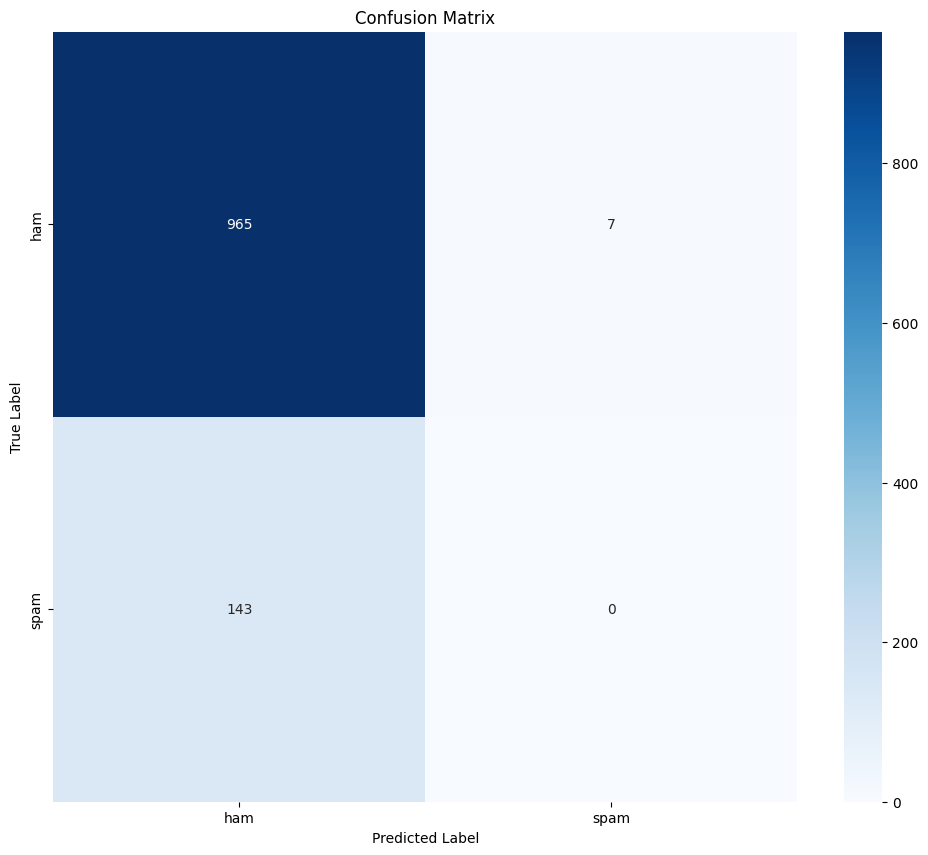

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       972
         1.0       0.00      0.00      0.00       143

    accuracy                           0.87      1115
   macro avg       0.44      0.50      0.46      1115
weighted avg       0.76      0.87      0.81      1115



In [26]:
evaluate_model(my_model.model, SMSSpamCollection_tf_data_valid, lb.classes_)

---
#### Hal ini menunjukkan bahwa 933 dari 946 pesan reguler (ham) diklasifikasikan dengan benar, sementara 39 dari 169 pesan spam diklasifikasikan dengan benar.
---